## CPSC 8430 Fall 24 HW 1_2c

#### 1. Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
# Enable anomaly detection for debugging
torch.autograd.set_detect_anomaly(True)

#### 2. Define DNN

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(1, 16)  # Input size is 1 (for x)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Function to generate data

In [4]:
def generate_data(num_samples):
    x = torch.rand(num_samples, 1)  # Random x values between 0 and 1
    y = torch.sin(5 * torch.pi * x) / (5 * torch.pi * x)  # Calculate corresponding y values
    return x, y

#### 3. Function for calculating gradient norm (p=2)

In [5]:
def calculate_gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grad
    grad_norm = grad_all ** 0.5
    return grad_norm

#### 4. Function for calculating Hessian matrix

In [6]:
def compute_hessian_diagonal(model, loss):
    hessian = []
    for param in model.parameters():
        grad_params = grad(loss, param, create_graph=True)[0]
        grad_params_flat = grad_params.contiguous().view(-1)
        row = []
        for g in grad_params_flat:
            grad2nd = grad(g, param, retain_graph=True)[0]
            row.append(grad2nd.contiguous().view(-1))
        hessian.append(torch.cat(row))
    return torch.cat(hessian).diag()

#### 5. Function for calculating minimul ratio

In [7]:
def compute_minimal_ratio(hessian):
    eigenvalues = torch.linalg.eigvalsh(hessian.cpu())
    positive_eigenvalues = torch.sum(eigenvalues > 0)
    total_eigenvalues = len(eigenvalues)
    minimal_ratio = positive_eigenvalues.item() / total_eigenvalues
    return minimal_ratio

#### 6. Function to compute losses and sample weights

In [8]:
def sample_and_compute_loss(model, theta_0, sample_count, loss_function, inputs, labels):
    sampled_losses = []
    for _ in range(sample_count):
        # Generate random weights around theta_0
        sampled_params = [p + torch.randn_like(p) * 0.01 for p in theta_0]
        for param, sample in zip(model.parameters(), sampled_params):
            param.data.copy_(sample)

        # Compute the loss for this sampled weight set
        outputs = model(inputs)
        loss_sample = loss_function(outputs, labels)
        sampled_losses.append(loss_sample.item())

    return sampled_losses

#### 6. Training loop

In [9]:
# Training parameters
epochs = 100
grad_norm_threshold = 5e-5  # Threshold to switch to gradient norm minimization
minimal_ratios = []
losses = []
early_stopping_patience = 10 

# Generate data
num_samples = 1000
x, y = generate_data(num_samples)

# Initialize model and optimizer
model = DNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(epochs):
    for i in range(num_samples):
        model.zero_grad()
        outputs = model(x[i].unsqueeze(0))  
        loss = nn.MSELoss()(outputs, y[i].unsqueeze(0))
        loss.backward(retain_graph=True)  # retain the graph for second-order derivatives

        grad_norm = calculate_gradient_norm(model)

        # Switch to minimizing gradient norm if it is below the threshold
        if grad_norm < grad_norm_threshold:
            print(f"Epoch {epoch + 1}, Iteration {i + 1}, Switching to Gradient Norm Minimization")

            # Compute Hessian (using diagonal approximation)
            hessian = compute_hessian_diagonal(model, loss)
            print("Hessian computation done")

            # Compute minimal ratio using the Hessian's eigenvalues
            minimal_ratio = compute_minimal_ratio(hessian)
            minimal_ratios.append(minimal_ratio)
            print("Minimal Ratio computation done")

            # Sample multiple weights around this point and compute losses
            theta_0 = [p.data.clone() for p in model.parameters()]  # Save the current weights (theta_0)
            sampled_losses = sample_and_compute_loss(model, theta_0, sample_count=10,
                                                    loss_function=nn.MSELoss(),
                                                    inputs=x[i].unsqueeze(0), labels=y[i].unsqueeze(0))

            # Calculate how many of the sampled losses are greater than the original loss
            proportion_greater = sum([1 for sl in sampled_losses if sl > loss.item()]) / len(sampled_losses)

            # Print the detailed output
            print(f"Epoch {epoch + 1}, Iteration {i + 1}, Loss: {loss.item():.6f}, Minimal Ratio: {minimal_ratio:.6f}, Proportion L(sample) > L(theta_0): {proportion_greater:.6f}")

            losses.append(loss.item())

        # Update weights at the end using optimizer based on the original loss
        optimizer.step()

    # Print outputs for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Gradient Norm: {grad_norm:.4f}')

    # Early stopping check
    if len(minimal_ratios) > early_stopping_patience and all(mr < minimal_ratios[-early_stopping_patience] for mr in minimal_ratios[-early_stopping_patience:]):
        print("Early stopping triggered!")
        break

Epoch 1/100, Loss: 0.0031, Gradient Norm: 0.2131
Epoch 2/100, Loss: 0.0141, Gradient Norm: 0.5139
Epoch 3/100, Loss: 0.0218, Gradient Norm: 0.6942
Epoch 4/100, Loss: 0.0196, Gradient Norm: 0.6629
Epoch 5/100, Loss: 0.0163, Gradient Norm: 0.6035
Epoch 6/100, Loss: 0.0123, Gradient Norm: 0.5283
Epoch 7/100, Loss: 0.0092, Gradient Norm: 0.4663
Epoch 8/100, Loss: 0.0068, Gradient Norm: 0.4113
Epoch 9/100, Loss: 0.0049, Gradient Norm: 0.3617
Epoch 10, Iteration 154, Switching to Gradient Norm Minimization
Hessian computation done
Minimal Ratio computation done
Epoch 10, Iteration 154, Loss: 0.000000, Minimal Ratio: 0.146667, Proportion L(sample) > L(theta_0): 1.000000
Epoch 10/100, Loss: 0.0042, Gradient Norm: 0.3436
Epoch 11/100, Loss: 0.0034, Gradient Norm: 0.3224
Epoch 12/100, Loss: 0.0028, Gradient Norm: 0.3101
Epoch 13/100, Loss: 0.0023, Gradient Norm: 0.2903
Epoch 14, Iteration 786, Switching to Gradient Norm Minimization
Hessian computation done
Minimal Ratio computation done
Epoch 1

#### 7. Plotting minimal ratio vs loss

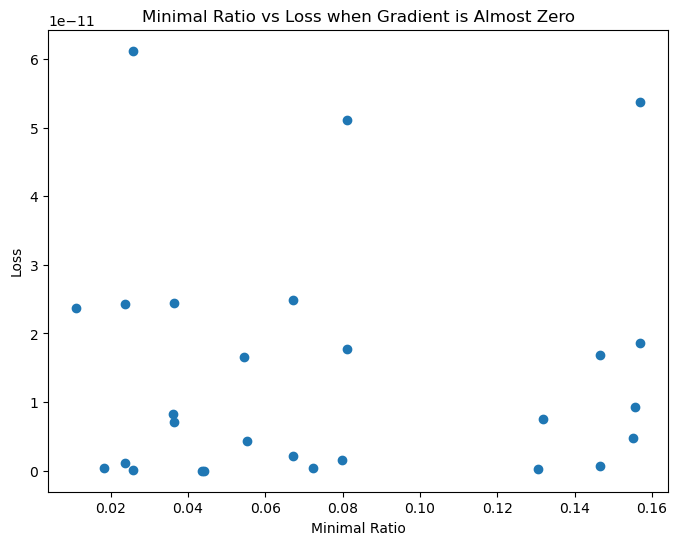

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(minimal_ratios, losses)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.title('Minimal Ratio vs Loss when Gradient is Almost Zero')
plt.show()